In [1]:
from PIL import Image
import cv2
import sys
import os
import urllib
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import time
from tf_trt_models.detection import download_detection_model, build_detection_graph

%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





### Download an SSD model for face detection

In [2]:
# https://github.com/yeephycho/tensorflow-face-detection
FROZEN_GRAPH_NAME = 'data/frozen_inference_graph_face.pb'
#FROZEN_GRAPH_NAME = 'data/frozen_inference_graph.pb'
#FROZEN_GRAPH_NAME = 'data/frozen_inference_graph_fastrnn.pb'
#!wget https://github.com/yeephycho/tensorflow-face-detection/blob/master/model/frozen_inference_graph_face.pb?raw=true -O {FROZEN_GRAPH_NAME}

### Download an image with some faces

In [3]:
# go warriors!
#IMAGE_PATH = 'data/warriors.jpg'
#IMAGE_PATH = 'data/cp-15-99tickets-cta.jpg'
IMAGE_PATH = 'data'
#!wget 'https://cdn.vox-cdn.com/thumbor/rC0mlBATZdoDW1tEa44P6431sGc=/0x0:3683x2455/1200x800/filters:focal(1623x234:2211x822)/cdn.vox-cdn.com/uploads/chorus_image/image/63273148/usa_today_12005182.0.jpg' -O {IMAGE_PATH}
#!wget 'https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.cedarpoint.com%2Ftickets-passes%2Fgroup-tickets&psig=AOvVaw1NVQud1IndRltK49OH0gXl&ust=1592200051404000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCIiptsrNgOoCFQAAAAAdAAAAABAE' -O {IMAGE_PATH}

### Load the frozen graph

In [4]:
output_dir=''
frozen_graph = tf.GraphDef()
with open(os.path.join(output_dir, FROZEN_GRAPH_NAME), 'rb') as f:
  frozen_graph.ParseFromString(f.read())

### A few magical constants

In [5]:
# https://github.com/NVIDIA-AI-IOT/tf_trt_models/blob/master/tf_trt_models/detection.py
INPUT_NAME='image_tensor'
BOXES_NAME='detection_boxes'
CLASSES_NAME='detection_classes'
SCORES_NAME='detection_scores'
MASKS_NAME='detection_masks'
NUM_DETECTIONS_NAME='num_detections'

input_names = [INPUT_NAME]
output_names = [BOXES_NAME, CLASSES_NAME, SCORES_NAME, NUM_DETECTIONS_NAME]

### Optimize the frozen graph using TensorRT

In [6]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

INFO:tensorflow:Linked TensorRT version: (6, 0, 1)
INFO:tensorflow:Loaded TensorRT version: (6, 0, 1)
INFO:tensorflow:Running against TensorRT version 6.0.1


### Create session and load graph

In [10]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

# use this if you want to try on the optimized TensorRT graph
# Note that this will take a while
# tf.import_graph_def(trt_graph, name='')

# use this if you want to try directly on the frozen TF graph
# this is much faster
tf.import_graph_def(frozen_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

### Capture Image

In [84]:
cam = cv2.VideoCapture(1)
img_counter = 0
images = []

while True:
    ret, frame = cam.read()

    # Our operations on the frame come here
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    
    if not ret:
        print("failed to grab frame")
        break
#    cv2.imshow('frame', gray)

    img_name = "opencv_frame_{}.jpg".format(img_counter)
    #cv2.imwrite((IMAGE_PATH + "/" + img_name), gray)
    cv2.imwrite((IMAGE_PATH + "/" + img_name), frame)
    images.append(IMAGE_PATH + "/" + img_name)
    print("{} written!".format(img_name))
    img_counter += 1

    if img_counter == 4:
        break
    
cam.release()
print("cam released...")
cv2.destroyAllWindows()

opencv_frame_0.jpg written!
opencv_frame_1.jpg written!
opencv_frame_2.jpg written!
opencv_frame_3.jpg written!
cam released...


### Load and Preprocess Image

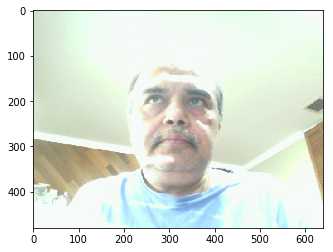

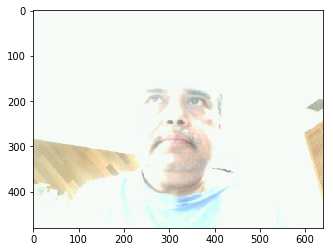

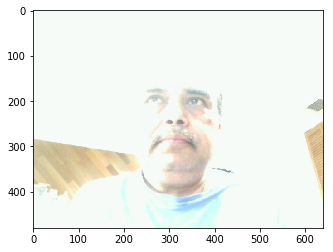

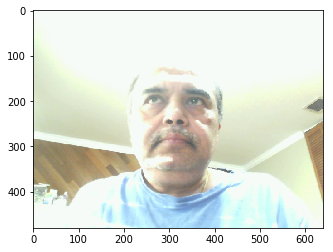

In [85]:
for file in images:
    img = Image.open(file)
    fig = plt.figure()
    plt.imshow(img)
    image_resized = np.array(img.resize((300, 300)))
    img = np.array(img)

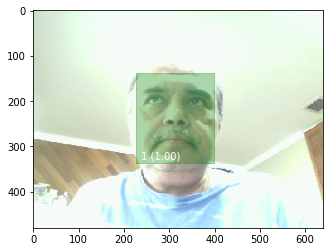

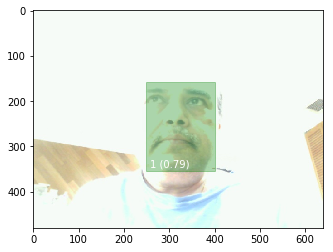

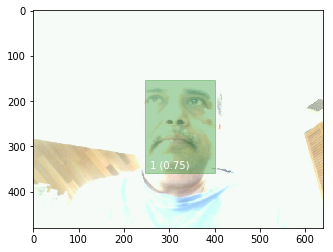

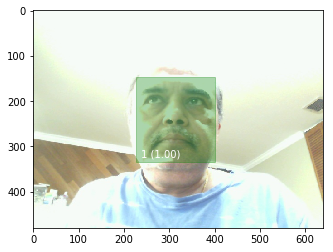

In [86]:
for file in images:
    img = Image.open(file)
    fig = plt.figure()
    plt.imshow(img)
    image_resized = np.array(img.resize((300, 300)))
    img = np.array(img)
    
    # Run network on Image
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image_resized[None, ...]
    })

    boxes = boxes[0] # index by 0 to remove batch dimension
    scores = scores[0]
    classes = classes[0]
    num_detections = num_detections[0]
    
    # suppress boxes that are below the threshold.. 
    DETECTION_THRESHOLD = 0.5
       
    # Display Results
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)

    # plot boxes exceeding score threshold
    for i in range(int(num_detections)):
        if scores[i] < DETECTION_THRESHOLD:
            continue
        # scale box to image coordinates
        box = boxes[i] * np.array([img.shape[0], img.shape[1], img.shape[0], img.shape[1]])

        # display rectangle
        patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
        ax.add_patch(patch)

        # display class index and score
        plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

    plt.show()

### Benchmark

In [87]:
num_samples = 50

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_resized[None, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / num_samples))

Average runtime: 0.085790 seconds


### Close session to release resources

In [13]:
tf_sess.close()